# Gesture Recognition

### Team members:

*   Dhruv Ajmeri
*   Umesh Pandey
*   Mariam Abbas Zaidi

**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |



### Objectives:
1. **Generator**: Ensure the generator can process a batch of videos without encountering any errors. Perform necessary steps such as cropping, resizing, and normalization successfully.

2. **Model**: Create a model that can be trained without any errors. Evaluate the model based on the total number of parameters (considering faster inference/prediction time) and the achieved accuracy. It is recommended to start training with a small amount of data and gradually proceed.

3. **Write up**: Include a detailed procedure describing the process followed to select the final model. Begin with an explanation of the rationale behind choosing the base model. Then, discuss the reasons and metrics considered when modifying and experimenting to reach the final model.

In [ ]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Setting up random seed to generate same results in every run.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-06-05 23:16:52.544424: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-05 23:16:52.544489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [ ]:
## Checking the GPU configuration
!nvidia-smi

Mon Jun  5 23:16:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1D:00.0 Off |                  Off |
| 33%   41C    P2    47W / 230W |    259MiB / 16384MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


Within this section, you extract the names of the folders designated for training and validation. Additionally, the `size_of_a_batch` is defined at this point. It's important to ensure that the batch size is optimized to fully utilize the GPU's capabilities. Consequently, you gradually increase the batch size until an error is encountered by the machine.

In [ ]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
size_of_a_batch = 64

## Generator
This section holds significant importance within the code. The generator's overall structure has already been provided. In this portion, you will be performing preprocessing on the images, considering the presence of two different image dimensions, and generating a batch of video frames. You are encouraged to experiment with `img_idx`, `y`, `z`, and normalization techniques in order to achieve optimal accuracy.

In [ ]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [ ]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if image is smaller then crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]
    # resizing every image
    return resize(image, (y,z))

In [ ]:
def preprocess_Image(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [ ]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [ ]:
def generator(source_path, list_of_folders, size_of_a_batch, Image_tensor):
    print( 'Source path = ', source_path, '; batch size =', size_of_a_batch)
    while True:
        t = np.random.permutation(list_of_folders)
        num_batches = int(len(list_of_folders)/size_of_a_batch)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, size_of_a_batch, Image_tensor)
        
        # Implement the code to handle the remaining data points that are not part of complete batches.
        # checking for remaining batches
        if len(list_of_folders)%size_of_a_batch != 0:
            # updating the batch yield and size 
            size_of_a_batch = len(list_of_folders)%size_of_a_batch
            yield getBatchData(source_path, t, batch, size_of_a_batch, Image_tensor)

In [ ]:
def getBatchData(source_path, t, batch, size_of_a_batch, Image_tensor):
    [x,y,z] = [len(Image_tensor[0]),Image_tensor[1], Image_tensor[2]]
    img_idx = Image_tensor[0]
    Batch_data = np.zeros((size_of_a_batch,x,y,z,3)) # For each video, you utilize 'x' images, where (y, z) represents the desired final size of the input images. Additionally, the number '3' signifies the RGB channels.
    batch_label = np.zeros((size_of_a_batch,5)) # The variable 'batch_label' corresponds to the one-hot representation of the output.
    for folder in range(size_of_a_batch): # iterating over the size_of_a_batch
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*size_of_a_batch)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*size_of_a_batch)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            # A separate function called 'preprocess_Image' is defined to handle the tasks of cropping, resizing, and normalizing images.
            Batch_data[folder,idx,:,:,0] = preprocess_Image(image[:, :, 0], y, z)
            Batch_data[folder,idx,:,:,1] = preprocess_Image(image[:, :, 1], y, z)
            Batch_data[folder,idx,:,:,2] = preprocess_Image(image[:, :, 2], y, z)

        batch_label[folder, int(t[folder + (batch*size_of_a_batch)].strip().split(';')[2])] = 1
    return Batch_data, batch_label

When designing the model architecture, it is crucial to consider that a video is represented within the generator as (number of images, height, width, number of channels). Please keep this representation in mind while creating the model's architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_of_train_seq = len(train_doc)
print('# training sequences =', num_of_train_seq)
num_of_value_seq = len(val_doc)
print('# validation sequences =', num_of_value_seq)
no_of_epochs = 10
print ('# epochs =', no_of_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
def GetImageTensor(no_of_frames):
    img_idx = np.round(np.linspace(0, 29, no_of_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
Image_tensor = GetImageTensor(20)
print ('# Image_tensor =', Image_tensor)

# Image_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


### Generator Validation

In [ ]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
Batch_data_sample, sample_batch_label = next(sample_generator)
print(Batch_data_sample.shape)

Source path =  datasets/Project_data/train ; batch size = 64
(64, 20, 100, 100, 3)


In [ ]:
# validation batch sample
sample_val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)
sample_val_Batch_data, sample_val_batch_label = next(sample_val_generator)
print(sample_val_Batch_data.shape)

Source path =  datasets/Project_data/val ; batch size = 64
(64, 20, 100, 100, 3)


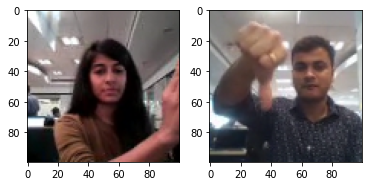

In [ ]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_Batch_data[16,10,:,:,:])   
ax[1].imshow(sample_val_Batch_data[25,10,:,:,:])
plt.show()

In [ ]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text(" Training accuracy vs Validation accuracy")
    plt.show()
    
    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

## Model Building
In this section, you construct the model utilizing various functionalities provided by Keras. It is essential to utilize `Conv3D` and `MaxPooling3D`, rather than `Conv2D` and `MaxPooling2D`, when building a 3D convolution model. If you are building a Conv2D + RNN model, you should incorporate `TimeDistributed`. Additionally, keep in mind that the last layer should be a softmax layer. Design the network with the objective of achieving high accuracy while utilizing the fewest number of parameters possible, enabling it to fit within the memory constraints of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

### Base Model

In [ ]:
def defineModel(Image_tensor):
    inputShape = (len(Image_tensor[0]), Image_tensor[1], Image_tensor[2], Image_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(Image_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 48, 48, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 48, 48, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                        

2023-06-05 23:17:14.191882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [ ]:
training_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)

The 'steps_per_epoch' and 'validation_steps' parameters are utilized by the 'fit_generator' function to determine the number of 'next()' calls it needs to make. These values determine how many iterations or batches of data will be processed during each epoch for training and validation, respectively.

In [ ]:
if (num_of_train_seq%size_of_a_batch) == 0:
    steps_per_epoch = int(num_of_train_seq/size_of_a_batch)
else:
    steps_per_epoch = (num_of_train_seq//size_of_a_batch) + 1

if (num_of_value_seq%size_of_a_batch) == 0:
    validation_steps = int(num_of_value_seq/size_of_a_batch)
else:
    validation_steps = (num_of_value_seq//size_of_a_batch) + 1

### Model Callbacks Setup

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

# callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

### Test Batch Size & Frames

In [ ]:
def testBatchSize(size_of_a_batch, no_of_frames):
    Image_tensor = GetImageTensor(no_of_frames)
    print("Using frames as", Image_tensor[0])
    global callbacks_list
    no_of_epochs = 3
    training_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
    val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)
    if (num_of_train_seq%size_of_a_batch) == 0:
        steps_per_epoch = int(num_of_train_seq/size_of_a_batch)
    else:
        steps_per_epoch = (num_of_train_seq//size_of_a_batch) + 1

    if (num_of_value_seq%size_of_a_batch) == 0:
        validation_steps = int(num_of_value_seq/size_of_a_batch)
    else:
        validation_steps = (num_of_value_seq//size_of_a_batch) + 1

    model = defineModel(Image_tensor)
    model.fit_generator(training_generator, steps_per_epoch=steps_per_epoch, epochs=no_of_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# testBatchSize(size_of_a_batch=64, no_of_frames=30)

In [ ]:
# testBatchSize(size_of_a_batch=64, no_of_frames=16)

In [ ]:
# testBatchSize(size_of_a_batch=32, no_of_frames=30)

In [ ]:
# testBatchSize(size_of_a_batch=32, no_of_frames=16)

Based on the aforementioned observations, it is apparent that the batch size does not significantly impact the training time; rather, it is the number of frames that has a greater impact. Considering this, a batch size of 64 has been determined to be optimal. However, it is commented out in the code since running it consumes a substantial amount of time, which may hinder the notebook from completing its execution.

### Model 1 - Frames-16, Epoc-20

In [ ]:
no_of_frames = 16
no_of_epochs = 20
size_of_a_batch = 64

Image_tensor = GetImageTensor(no_of_frames)
training_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)

if (num_of_train_seq%size_of_a_batch) == 0:
    steps_per_epoch = int(num_of_train_seq/size_of_a_batch)
else:
    steps_per_epoch = (num_of_train_seq//size_of_a_batch) + 1

if (num_of_value_seq%size_of_a_batch) == 0:
    validation_steps = int(num_of_value_seq/size_of_a_batch)
else:
    validation_steps = (num_of_value_seq//size_of_a_batch) + 1
    
inputShape = (len(Image_tensor[0]), Image_tensor[1], Image_tensor[2], Image_tensor[3])

model_1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model_1.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_1.summary())

model_1_history = model_1.fit_generator(training_generator, steps_per_epoch=steps_per_epoch, epochs=no_of_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 12, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 6, 48, 48, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 23, 23, 32)    0         
 3D)                                                             
                                                          

2023-06-05 23:17:24.806264: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - 102s 10s/step - loss: 1.4840 - categorical_accuracy: 0.4434 - val_loss: 4.3440 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 44s 4s/step - loss: 0.9455 - categorical_accuracy: 0.6443 - val_loss: 4.9210 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 42s 4s/step - loss: 0.9136 - categorical_accuracy: 0.6877 - val_loss: 4.3319 - val_categorical_accuracy: 0.2321 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 38s 4s/step - loss: 0.8816 - categorical_accuracy: 0.6481 - val_loss: 3.6328 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 32s 3s/step - loss: 0.6669 - categorical_accuracy: 0.7368 - val_loss: 2.4764 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 27s 3s/step - loss: 0.7047 - categorical_accuracy: 0.7273 - val_loss: 3.

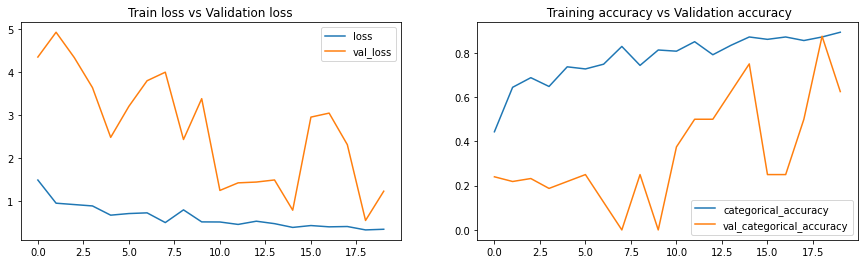

Max. Training Accuracy 0.893048107624054
Max. Validaiton Accuracy 0.875


In [ ]:
plotModelHistory(model_1_history)

### Model 2: Frames-30, Epocs-30

In [ ]:
no_of_frames = 30
no_of_epochs = 30
size_of_a_batch = 64

Image_tensor = GetImageTensor(no_of_frames)
training_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)

if (num_of_train_seq%size_of_a_batch) == 0:
    steps_per_epoch = int(num_of_train_seq/size_of_a_batch)
else:
    steps_per_epoch = (num_of_train_seq//size_of_a_batch) + 1

if (num_of_value_seq%size_of_a_batch) == 0:
    validation_steps = int(num_of_value_seq/size_of_a_batch)
else:
    validation_steps = (num_of_value_seq//size_of_a_batch) + 1
    
inputShape = (len(Image_tensor[0]), Image_tensor[1], Image_tensor[2], Image_tensor[3])

model_2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model_2.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

model_2_history = model_2.fit_generator(training_generator, steps_per_epoch=steps_per_epoch, epochs=no_of_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 26, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 13, 48, 48, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 13, 48, 48, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 11, 46, 46, 32)    13856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 11, 23, 23, 32)   0         
 3D)                                                             
                                                          

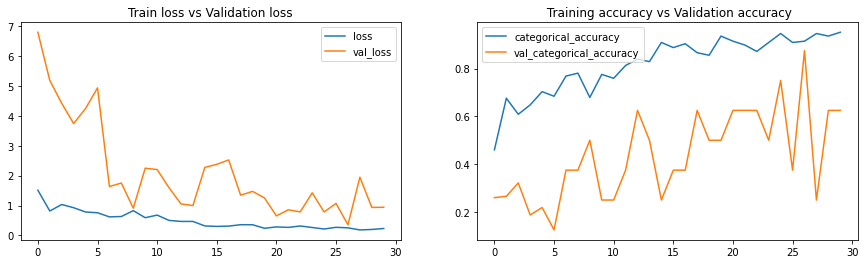

Max. Training Accuracy 0.9518716335296631
Max. Validaiton Accuracy 0.875


In [ ]:
plotModelHistory(model_2_history)

Reduce parameters, with padding in Conv3D layers and filter of (3,3,3).

### Model 3: Frames-30, Epocs-20, Reduced parameters

In [ ]:
no_of_frames = 30
no_of_epochs = 20
size_of_a_batch = 64

Image_tensor = GetImageTensor(no_of_frames)
training_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)

if (num_of_train_seq%size_of_a_batch) == 0:
    steps_per_epoch = int(num_of_train_seq/size_of_a_batch)
else:
    steps_per_epoch = (num_of_train_seq//size_of_a_batch) + 1

if (num_of_value_seq%size_of_a_batch) == 0:
    validation_steps = int(num_of_value_seq/size_of_a_batch)
else:
    validation_steps = (num_of_value_seq//size_of_a_batch) + 1
    
inputShape = (len(Image_tensor[0]), Image_tensor[1], Image_tensor[2], Image_tensor[3])

model_3 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")
model_3.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_3.summary())

model_3_history = model_3.fit_generator(training_generator, steps_per_epoch=steps_per_epoch, epochs=no_of_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 15, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 8, 25, 25, 32)    0         
 g3D)                                                            
                                                          

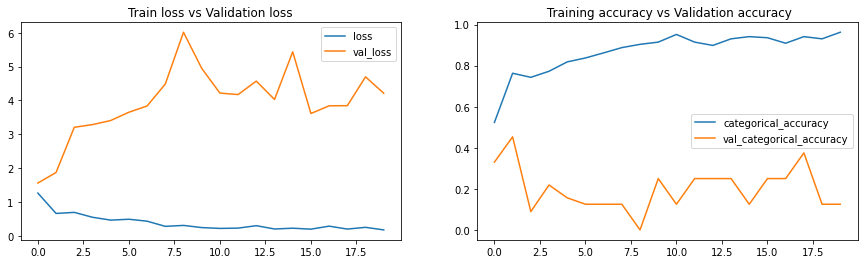

Max. Training Accuracy 0.9625668525695801
Max. Validaiton Accuracy 0.453125


In [ ]:
plotModelHistory(model_3_history)

### Model 4: Frames-20, Same pooling in Conv3D layer

In [ ]:
no_of_frames = 20
no_of_epochs = 20
size_of_a_batch = 64

Image_tensor = GetImageTensor(no_of_frames)
training_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)

if (num_of_train_seq%size_of_a_batch) == 0:
    steps_per_epoch = int(num_of_train_seq/size_of_a_batch)
else:
    steps_per_epoch = (num_of_train_seq//size_of_a_batch) + 1

if (num_of_value_seq%size_of_a_batch) == 0:
    validation_steps = int(num_of_value_seq/size_of_a_batch)
else:
    validation_steps = (num_of_value_seq//size_of_a_batch) + 1
    
inputShape = (len(Image_tensor[0]), Image_tensor[1], Image_tensor[2], Image_tensor[3])

model_4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")
model_4.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4.summary())

model_4_history = model_4.fit_generator(training_generator, steps_per_epoch=steps_per_epoch, epochs=no_of_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 20, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_25 (Bat  (None, 10, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_16 (Conv3D)          (None, 10, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 5, 25, 25, 32)    0         
 g3D)                                                            
                                                          

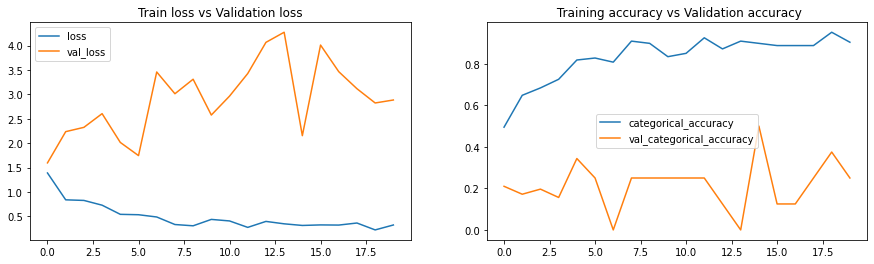

Max. Training Accuracy 0.9518716335296631
Max. Validaiton Accuracy 0.5


In [ ]:
plotModelHistory(model_4_history)

### Model 5: Frames:20, Epocs-20, BS-64, reduced kernel to (2,2,2), switching BatchNormalization before MaxPooling.

In [ ]:
no_of_frames = 20
no_of_epochs = 20
size_of_a_batch = 64

Image_tensor = GetImageTensor(no_of_frames)
training_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)

if (num_of_train_seq%size_of_a_batch) == 0:
    steps_per_epoch = int(num_of_train_seq/size_of_a_batch)
else:
    steps_per_epoch = (num_of_train_seq//size_of_a_batch) + 1

if (num_of_value_seq%size_of_a_batch) == 0:
    validation_steps = int(num_of_value_seq/size_of_a_batch)
else:
    validation_steps = (num_of_value_seq//size_of_a_batch) + 1
    
inputShape = (len(Image_tensor[0]), Image_tensor[1], Image_tensor[2], Image_tensor[3])

model_5 = Sequential([
    Conv3D(16, make3dFilter(2), padding='same', activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2)),

    Conv3D(32, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Flatten(),
    Dense(256, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.3),

    Dense(128, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_3d5")
model_5.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_5.summary())

model_5_history = model_5.fit_generator(training_generator, steps_per_epoch=steps_per_epoch, epochs=no_of_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_19 (Conv3D)          (None, 20, 100, 100, 16)  400       
                                                                 
 batch_normalization_31 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_20 (Conv3D)          (None, 10, 50, 50, 32)    4128      
                                                                 
 batch_normalization_32 (Bat  (None, 10, 50, 50, 32)   128       
 chNormalization)                                                
                                                          

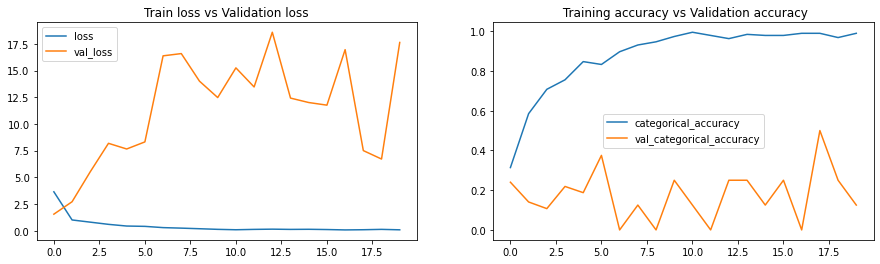

Max. Training Accuracy 0.9946523904800415
Max. Validaiton Accuracy 0.5


In [ ]:
plotModelHistory(model_5_history)

### Model 6: Switching Model architecture to Conv2D+LSTM

In [ ]:
no_of_frames = 20
no_of_epochs = 30
size_of_a_batch = 32

Image_tensor = GetImageTensor(no_of_frames)
training_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)

if (num_of_train_seq%size_of_a_batch) == 0:
    steps_per_epoch = int(num_of_train_seq/size_of_a_batch)
else:
    steps_per_epoch = (num_of_train_seq//size_of_a_batch) + 1

if (num_of_value_seq%size_of_a_batch) == 0:
    validation_steps = int(num_of_value_seq/size_of_a_batch)
else:
    validation_steps = (num_of_value_seq//size_of_a_batch) + 1
    
inputShape = (len(Image_tensor[0]), Image_tensor[1], Image_tensor[2], Image_tensor[3])

model_6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model_6.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_6.summary())

model_6_history = model_6.fit_generator(training_generator, steps_per_epoch=steps_per_epoch, epochs=no_of_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 32)  

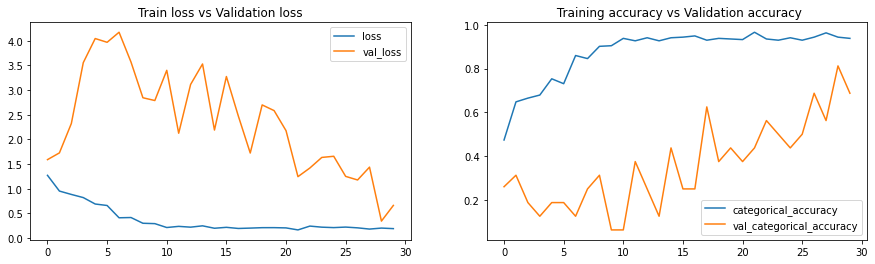

Max. Training Accuracy 0.9663865566253662
Max. Validaiton Accuracy 0.8125


In [ ]:
plotModelHistory(model_6_history)

### Model 7: Transfer Learning (MobileNet) with LSTM

In [ ]:
from tensorflow.keras.applications import mobilenet

In [ ]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

no_of_frames = 20
no_of_epochs = 30
size_of_a_batch = 64

Image_tensor = GetImageTensor(no_of_frames)
training_generator = generator(train_path, train_doc, size_of_a_batch, Image_tensor)
val_generator = generator(val_path, val_doc, size_of_a_batch, Image_tensor)

if (num_of_train_seq%size_of_a_batch) == 0:
    steps_per_epoch = int(num_of_train_seq/size_of_a_batch)
else:
    steps_per_epoch = (num_of_train_seq//size_of_a_batch) + 1

if (num_of_value_seq%size_of_a_batch) == 0:
    validation_steps = int(num_of_value_seq/size_of_a_batch)
else:
    validation_steps = (num_of_value_seq//size_of_a_batch) + 1
    
inputShape = (len(Image_tensor[0]), Image_tensor[1], Image_tensor[2], Image_tensor[3])

model_7 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model_7.layers:
    layer.trainable = False

model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model_7.add(TimeDistributed(Flatten()))

model_7.add(LSTM(256))
model_7.add(Dropout(0.2))

model_7.add(Dense(256,activation='relu'))
model_7.add(Dropout(0.2))

model_7.add(Dense(5, activation='softmax'))

model_7.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_7.summary())

model_7_history = model_7.fit_generator(training_generator, steps_per_epoch=steps_per_epoch, epochs=no_of_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

17235968/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                     

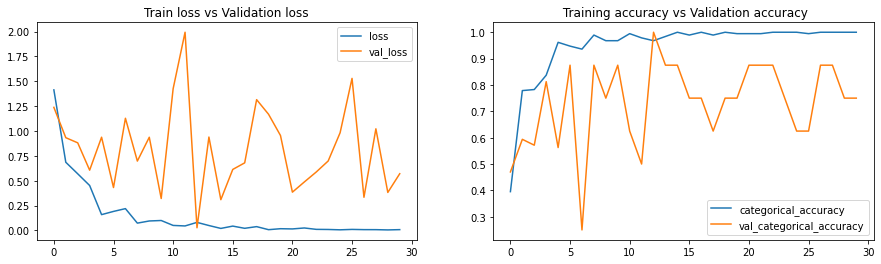

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 1.0


In [ ]:
plotModelHistory(model_7_history)

# ----------------------------------------------------Thank you---------------------------------------
